## 031 データを読み込んで確認する

In [38]:
import pandas as pd
uselog = pd.read_csv('./input/100knoks/03/use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [39]:
customer = pd.read_csv('./input/100knoks/03/customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

## 032 クラスタリングで顧客をグループ化

In [40]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']].copy()
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)
customer_clustering_sc

array([[-0.28120614, -0.13367635,  0.08117747, -0.5336197 ,  2.03402524],
       [-0.14054502, -0.13367635, -0.37992814, -0.02114919,  2.03402524],
       [-0.42186727, -0.13367635, -0.84103375, -0.02114919,  2.03402524],
       ...,
       [ 1.50050144,  1.46662237,  0.08117747,  2.54120338, -1.28811491],
       [ 3.18843493,  3.06692109,  1.46449428,  4.07861492, -1.28811491],
       [ 2.62579043,  2.53348819,  1.00338868,  3.56614441, -1.28811491]])

In [42]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique())
customer_clustering.head()

[1 2 3 0]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


## 033 クラスタリング結果の分析

In [43]:
customer_clustering.columns = ['月内平均', '月内中央値', '月内最大値', '月内最小値', '会員期間', 'cluster']
customer_clustering.groupby('cluster').count()

,月内平均,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [44]:
customer_clustering.groupby('cluster').mean()

,月内平均,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


### 解析
クループ0: 会員期間が長いが利用率が高いグループ  
グループ1: 会員期間が最も長い  
グループ2: 会員期間が短く利用率も低いグループ  
グループ3: 会員期間が平均的に長く、利用率も平均的なグループ

## 034  クラスタリング結果の可視化
主成分分析を行い次元を削除し2次元での可視化を行う。

In [45]:
from  sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']
pca_df

,0,1,cluster
0,-0.819982,-1.959097,1
1,-0.707922,-1.799857,1
2,-1.061499,-1.659826,1
3,-1.160764,-1.810139,1
4,-2.017132,-1.670101,1
...,...,...,...
4187,3.027933,1.139635,0
4188,5.064720,0.769684,0
4189,3.027933,1.139635,0
4190,6.083114,0.584708,0


<AxesSubplot:xlabel='0', ylabel='1'>

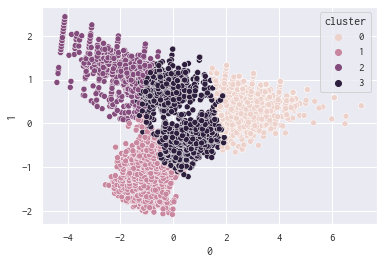

In [46]:
import seaborn as sns
sns.scatterplot(data=pca_df, x=0, y=1, hue='cluster')

<AxesSubplot:xlabel='会員期間', ylabel='月内平均'>

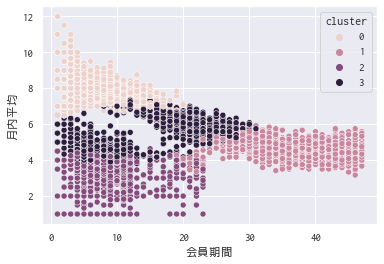

In [47]:
import seaborn as sns
sns.set(font='Ricty')
sns.scatterplot(data=customer_clustering, x='会員期間', y='月内平均', hue='cluster')

## 035 クラスタリング結果から退会顧客の傾向を把握

In [48]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [49]:
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


## 036 翌月の利用回数予測を行う準備

In [50]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['年月'] = uselog['usedate'].dt.strftime("%Y%m")
uselog_months = uselog.groupby(['年月', 'customer_id'], as_index=False).count()
uselog_months.rename(columns={'log_id': 'count'}, inplace=True)
del uselog_months['usedate']
uselog_months

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


In [51]:
year_months = list(uselog_months['年月'].unique())
print(year_months)
predict_date = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months['年月'] == year_months[i]].copy()
    tmp.rename(columns={'count': 'count_pred'}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months['年月'] == year_months[i-j]].copy()
        del tmp_before['年月']
        tmp_before.rename(columns={'count': "count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')
    predict_date = pd.concat([predict_date, tmp], ignore_index=True)
predict_date.head()

['201804', '201805', '201806', '201807', '201808', '201809', '201810', '201811', '201812', '201901', '201902', '201903']


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


### 6ヶ月以上利用者に限定

In [52]:
predict_date = predict_date.dropna()
predict_date = predict_date.reset_index(drop=True)
predict_date.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [53]:
predict_date = pd.merge(predict_date, customer[['customer_id', 'start_date']], on='customer_id', how='left')
predict_date.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [58]:
predict_date['now_date'] = pd.to_datetime(predict_date['年月'], format="%Y%m")
predict_date['start_date'] = pd.to_datetime(predict_date['start_date'])

from dateutil.relativedelta import relativedelta
predict_date['period'] = None
for i in range(len(predict_date)):
    delta = relativedelta(predict_date['now_date'][i], predict_date['start_date'][i])
    predict_date.loc[i, 'period'] = delta.years * 12 + delta.months
predict_date.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


## 038 来月の利用回数予測モデルを作成


In [61]:
predict_date = predict_date.loc[predict_date['start_date'] >= pd.to_datetime('20180401')]
predict_date.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
49,201810,AS185951,1,5.0,3.0,3.0,7.0,3.0,10.0,2018-04-09,2018-10-01,5
55,201810,AS197200,12,6.0,8.0,9.0,6.0,8.0,8.0,2018-04-15,2018-10-01,5
56,201810,AS200286,3,6.0,3.0,6.0,6.0,7.0,10.0,2018-04-06,2018-10-01,5
72,201810,AS251169,2,4.0,6.0,5.0,8.0,10.0,7.0,2018-04-03,2018-10-01,5
96,201810,AS345469,1,3.0,5.0,6.0,5.0,4.0,7.0,2018-04-12,2018-10-01,5


In [64]:
from sklearn import linear_model
import sklearn.model_selection

model = linear_model.LinearRegression()
X = predict_date[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period']]
y = predict_date['count_pred']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)


LinearRegression()

In [65]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.5982967122504168
0.6314188565469614


## 039 モデルに寄与している変数を確認

In [66]:
coef = pd.DataFrame({'feature_names': X.columns, 'coefficient': model.coef_})
coef

,feature_names,coefficient
0,count_0,0.343906
1,count_1,0.177137
2,count_2,0.150041
3,count_3,0.185627
4,count_4,0.064077
5,count_5,0.083247
6,period,0.081705
